In [1]:
import os
import json
import math

import sys

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from matplotlib import ticker
from keras import layers, optimizers
from keras import Model
from keras.applications import DenseNet121
import random
# from keras.applications import VGG19
# from keras.applications.resnet50 import preprocess_input

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.models import Sequential

sys.path.append(os.path.abspath('../input/kerasefficientnetsmaster/keras-efficientnets-master/keras-efficientnets-master/'))
from keras_efficientnets import EfficientNetB5

from imgaug import augmenters as iaa
from keras.utils import Sequence
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import keras.backend as K
K.set_learning_phase(0)
import warnings
warnings.filterwarnings("ignore")
print(os.listdir('../input'))


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['efficientnet-keras-weights-b0b5', 'aptos2019-blindness-detection', 'aptos-efficientnet', 'kerasefficientnetsmaster']


In [2]:
def rotateAndScale(img, scaleFactor = 0.5, degreesCCW = 30):
    (oldY,oldX) = img.shape[0],img.shape[1] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    return rotatedImg

def crop_image(image, threshold=12):
    if len(image.shape) == 3:
        flatimage = np.max(image, 2)
    else:
        flatIimage = image
    assert len(flatimage.shape) == 2

    rows = np.where(np.max(flatimage, 0) > threshold)[0]
    
    if rows.size:
        cols = np.where(np.max(flatimage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1], rows[0]: rows[-1]]
    else:
        image = image[:1, :1]
    return image

def create_model(weights_path):
    inp = layers.Input(shape=(None, None, 3), name='image_input')
    base_model = EfficientNetB5(
        input_tensor=inp,
        weights=None,
        include_top=False
    )

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(2048,activation='relu')(x) 
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=inp, outputs=x)
    model.load_weights(weights_path)
    
    return model

In [3]:
path_test_img = "../input/aptos2019-blindness-detection/test_images"
path_test_excel = "../input/aptos2019-blindness-detection/sample_submission.csv"

df_test = pd.read_csv(path_test_excel)
df_test["diagnosis"] = np.random.randint(5, size=df_test.shape[0])

tta_steps = 7
image_size = 456
if df_test.shape[0]<2000:
    tta_steps = 7

scores_predicted = np.empty([tta_steps,len(df_test),5])
model_weight = '../input/aptos-efficientnet/model_loss5folds.h5'
model = create_model(model_weight)
for i, name in enumerate(df_test['id_code']):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')

    image = cv2.imread(path)
    image_cropped = crop_image(image)
    for step in range(tta_steps):

        image = rotateAndScale(image_cropped, scaleFactor = 0.5, degreesCCW = 45*step)
        image = cv2.resize(image, (image_size,image_size))
#         image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0) ,12) ,-4,128)

        score_predict = model.predict((image[np.newaxis])/255)
#         print(score_predict)
        scores_predicted[step,i,:] = score_predict

    if i%200 == 0:
        print('Numer added: {}/{}'.format(i,df_test['id_code'].size))

Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928


In [4]:
predicted = np.argmax(scores_predicted.mean(axis=0),axis=1)
df_test['diagnosis'] = predicted
df_test.to_csv('submission.csv',index=False)

df_test["diagnosis"].describe()

count    1928.000000
mean        1.676867
std         0.952883
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: diagnosis, dtype: float64

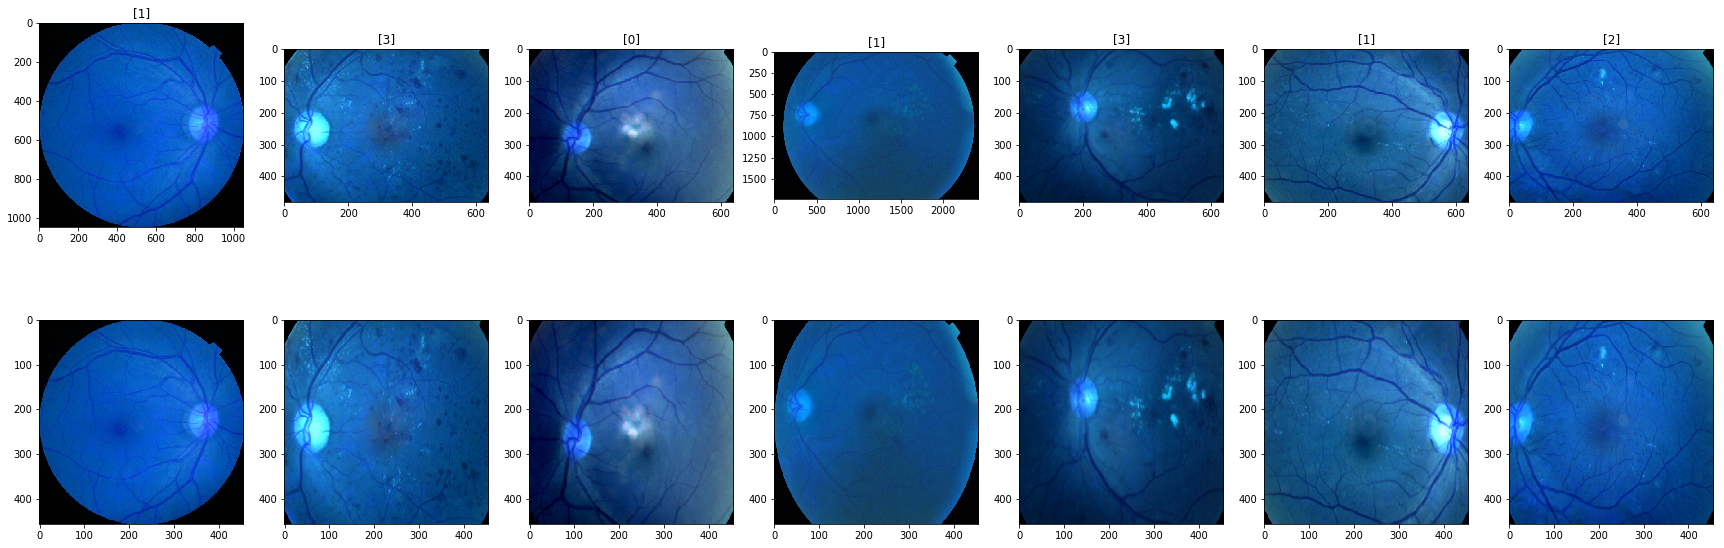

In [5]:
fig,ax = plt.subplots(2,7,figsize=(30,10))
for it,ID in enumerate(df_test["id_code"][7:14]):
    img = cv2.imread("../input/aptos2019-blindness-detection/test_images/{}.png".format(ID))          
    crop_img = crop_image(img)
    crop_img = cv2.resize(crop_img, (image_size,image_size))
#     crop_img = cv2.addWeighted(crop_img,4,cv2.GaussianBlur(crop_img,(0,0) ,10) ,-4,128)
    
    score_predict = model.predict((crop_img[np.newaxis])/255)
    ax[0][it].set_title(score_predict.argmax(axis=1))
    
    ax[0][it].imshow(img)
    ax[1][it].imshow(crop_img)

In [6]:
df_test.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
